In [2]:
# This section of the code is for all of my imports
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
from datetime import datetime
import glob
import matplotlib.cm as cm

# This allows me to access my flash drive that im working off of
os.chdir('/Volumes/Flash Drive')

In [3]:
# This Section is the formulas to convert from UTC to ET time, im working off of ET time

# This formula gets the UTC and ET offset due to leap seconds, number is in seconds
def utc_to_et_offset(year):
    """
    Get the offset between UTC and ET (TDB) in seconds for 2008.
    
    For 2008:
    - Leap seconds accumulated by 2008: 33 seconds
    - TT-TAI offset: 32.184 seconds
    - ET ≈ TDB ≈ TT for most purposes
    - So ET - UTC ≈ 33 + 32.184 = 65.184 seconds
    """
    
    ls = 33  # Leap Seconds since 2008

    # TT - TAI offset is always 32.184 seconds
    tt_tai_offset = 32.184
    
    # ET ≈ TDB ≈ TT = UTC + leap_seconds + 32.184
    et_utc_offset = ls + tt_tai_offset
    
    return et_utc_offset # Seconds

# This section of the code converts the UTC Julian Date to ET Julian Date adding in the leap seconds offset
def convert_paper_time_to_et(jd_utc):
    """
    Convert the paper's UTC-based Julian Date to ET-based Julian Date.
    
    Parameters:
    -----------
    jd_utc : float
        Julian Date in UTC (as used in the paper)
    
    Returns:
    --------
    jd_et : float
        Julian Date in Ephemeris Time
    """
    
    # Get offset for 2008
    et_utc_offset_2008 = utc_to_et_offset(2008)
    
    # Convert to ET
    initial_time = jd_utc + (et_utc_offset_2008 / 86400.0)
    
    return initial_time # Seconds

In [4]:
# This section defines the True Anamoly formula and the radius formula

def calculate_radius_true_anomaly(a, e, true_anomaly):
    """
    Calculate the radius at a given true anomaly for a Keplerian ellipse.
    
    This implements equation (2) from the paper:
    r(λ,t) = a(1 - e²) / (1 + e·cos(f))
    f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
    
    Parameters:
    -----------
    a : float
        Semi-major axis (km)
    e : float
        Eccentricity (dimensionless, between 0 and 1)
    true_anomaly : float or array
        True anomaly f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
        where λ is the inertial longitude and ϖ is the longitude of periapse
    
    Returns:
    --------
    r : float or array
        Radius at the given true anomaly (km)
    """

        # Convert to radians
    #true_anomaly = true_anomaly * np.pi / 180
    
    # Calculate the numerator: a(1 - e²)
    numerator = a * (1 - e**2)
    
    # Calculate the denominator: 1 + e·cos(f)
    denominator = 1 + e * np.cos(true_anomaly)
    
    # Calculate radius
    r = numerator / denominator
    
    return r

def calculate_true_anomaly(longitude #Inertial longitude (LON value)
                           ,varpi_0 # Longitude periapse (Fixed)
                           ,varpi_dot #Rrecession rate (Fixed)
                           ,time # Time from data
                           ,initial_time): # Time from paper (fixed)
    """
    Calculate the true anomaly from orbital parameters.
    
    From the paper: f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
    
    Parameters:
    -----------
    longitude : float or array
        Inertial longitude λ (degrees)
    varpi_0 (Longitude periapse) : float
        Longitude of periapse at epoch ϖ₀ (degrees)
    varpi_dot (precession rate) : float, optional
        Apsidal precession rate ϖ̇ (degrees/day)
    time : float, optional
        Current time (days)
    initial_time : float, optional
        Epoch time t₀ (days)
    
    Returns:
    --------
    true_anomaly : float or array
        True anomaly f (degrees)
    """
    
    # True anomaly is the angle from periapse
    true_anomaly = longitude - varpi_0 - varpi_dot * (time - initial_time)

    # Wrap to 0-360 degrees
    true_anomaly = true_anomaly % 360
    
    return true_anomaly

In [5]:
# This section defines static parameters

# J2000 epoch = JD 2451545.0
j2000_jd = 2451545.0

# Paper's epoch
paper_epoch_utc = 2454467.0  # This is in UTC

# Paper's epoch conversion to ET (seconds)
paper_epoch_jd_et = convert_paper_time_to_et(paper_epoch_utc)

# Static orbital parameters/Paper values (these don't change between occultations)
# Using median values for center of ringlet
a_paper = 77878.67  # km
e_paper = 2.88*10**-4

# Median parameters (averaged from inner and outer edge values)
aeI = 17.39    # ae Inner
aeO = 27.20    # ae Outer
ae_median = (aeI + aeO) / 2  # Median ae

varpi_0I = 270.54  # degrees Inner
varpi_0O = 270.70  # degrees Outer
varpi_0_median = (varpi_0I + varpi_0O) / 2  # Median longitude of periapse

varpi_dotI = 22.57503  # ϖ̇ in degrees/day Inner
varpi_dotO = 22.57562  # ϖ̇ in degrees/day Outer
varpi_dot_median = (varpi_dotI + varpi_dotO) / 2  # Median precession rate

Found 12 CSV files to process

Processing: BetCen_075I_1km_ringlet_individual_points.csv
  ✓ Processed 20 individual points from 1 occultation(s)
Processing: BetCen_077E_1km_ringlet_individual_points.csv
  ✓ Processed 32 individual points from 1 occultation(s)
Processing: BetCen_077I_1km_ringlet_individual_points.csv
  ✓ Processed 27 individual points from 1 occultation(s)
Processing: BetCen_078E_1km_ringlet_individual_points.csv
  ✓ Processed 34 individual points from 1 occultation(s)
Processing: BetCen_081I_1km_ringlet_individual_points.csv
  ✓ Processed 29 individual points from 1 occultation(s)
Processing: BetCen_085I_1km_ringlet_individual_points.csv
  ✓ Processed 42 individual points from 1 occultation(s)
Processing: BetCen_089I_1km_ringlet_individual_points.csv
  ✓ Processed 42 individual points from 1 occultation(s)
Processing: BetCen_092E_1km_ringlet_individual_points.csv
  ✓ Processed 38 individual points from 1 occultation(s)
Processing: BetCen_096I_1km_ringlet_individual_po

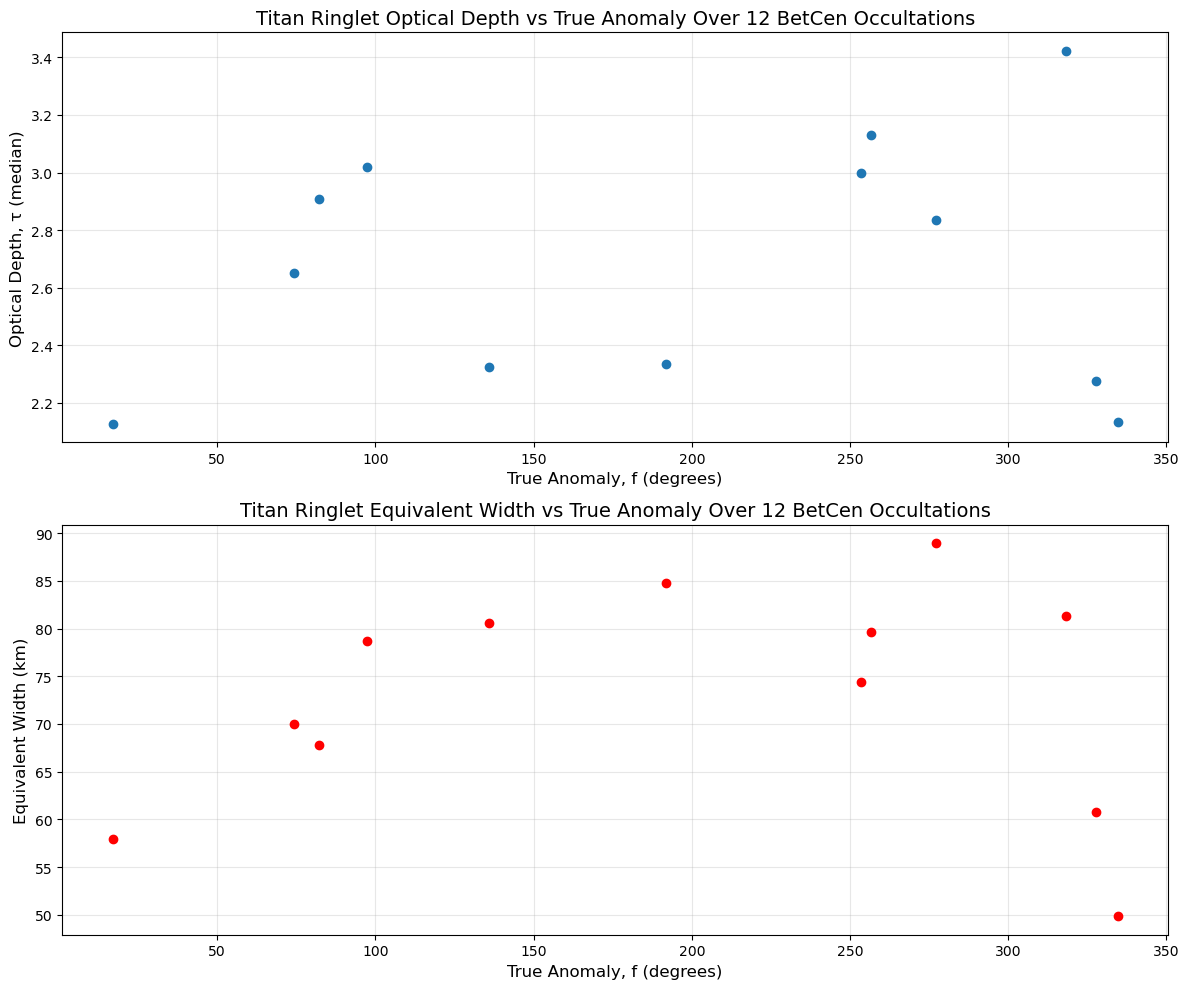


PHYSICAL WIDTH ANALYSIS:

Occultation          True Anom (°)   Phys Width (km)    Peak τ       Median τ     EQ Width (km)
---------------------------------------------------------------------------------------------------------
BetCen_077I_1km               16.95              26.0       4.795       2.127         57.987
BetCen_096I_1km               74.25              33.0       4.010       2.651         69.961
BetCen_081I_1km               82.23              28.0       4.877       2.909         67.794
BetCen_078E_1km               97.31              33.0       3.923       3.019         78.681
BetCen_085I_1km              135.80              41.0       4.075       2.324         80.528
BetCen_089I_1km              191.79              41.0       4.385       2.333         84.778
BetCen_104I_1km              253.52              32.0       4.189       3.000         74.353
BetCen_077E_1km              256.47              31.0       5.355       3.129         79.608
BetCen_092E_1km            

In [7]:
#This section codes and Graphs the True Anomoly and the EQ Width from the Total Ringlet CSV files

# Define the directory containing your CSV files
csv_directory = '/Volumes/Flash Drive/Saturns rings Research/Data From Center of Ringlets CSV files/Total Ringlet/'

# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(csv_directory, '*_1km_ringlet_individual_points.csv'))

print(f"Found {len(csv_files)} CSV files to process\n")

# Use your existing static parameters
varpi_0 = varpi_0_median  # 270.62 degrees
varpi_dot = varpi_dot_median  # 22.575325 degrees/day
initial_time_et = paper_epoch_jd_et  # Already converted to ET

# Bin width in km
bin_width = 1.0  # km

# Lists to store results from all files
all_eq_width_results = []
all_tau_results = []

# Process each CSV file
for csv_file in csv_files:
    csv_name = os.path.basename(csv_file)
    print(f"Processing: {csv_name}")
    
    try:
        # Load data from CSV
        data = pd.read_csv(csv_file)
        
        # Filter for only Titan ringlet data
        titan_data = data[data['Ringlet'] == 'Titan'].copy()
        
        if len(titan_data) == 0:
            print(f"  ⚠ No Titan ringlet data found in {csv_name}")
            continue
        
        # Calculate true anomaly for each data point
        titan_data['ET_days'] = titan_data['ET'] / 86400.0
        titan_data['JD_ET'] = j2000_jd + titan_data['ET_days']
        
        titan_data['true_anomaly'] = calculate_true_anomaly(
            longitude=titan_data['LON'],
            varpi_0=varpi_0,
            varpi_dot=varpi_dot,
            time=titan_data['JD_ET'],
            initial_time=initial_time_et
        )
        
        # Process each unique occultation in this file
        for occ in titan_data['Occultation'].unique():
            occ_data = titan_data[titan_data['Occultation'] == occ]
            
            # Calculate equivalent width: sum of all optical depths × bin width
            eq_width = np.sum(occ_data['Tau']) * bin_width
            
            # Get the true anomaly
            true_anom = occ_data['true_anomaly'].mean()
            
            # Store equivalent width results
            all_eq_width_results.append({
                'occultation': occ,
                'csv_file': csv_name,
                'true_anomaly': true_anom,
                'equivalent_width': eq_width,
                'num_points': len(occ_data)
            })
            
            # Store optical depth results (for comparison)
            all_tau_results.append({
                'occultation': occ,
                'csv_file': csv_name,
                'true_anomaly': true_anom,
                'tau_median': occ_data['Tau'].median(),
                'tau_mean': occ_data['Tau'].mean(),
                'radius_median': occ_data['Radius'].median()
            })
        
        print(f"  ✓ Processed {len(titan_data)} individual points from {titan_data['Occultation'].nunique()} occultation(s)")
        
    except Exception as ex:
        print(f"  ✗ Error processing {csv_name}: {ex}")
        import traceback
        traceback.print_exc()
        continue

# Convert to DataFrames
eq_width_df = pd.DataFrame(all_eq_width_results).sort_values('true_anomaly')
tau_df = pd.DataFrame(all_tau_results).sort_values('true_anomaly')

print(f"\n{'='*60}")
print(f"TOTAL DATA POINTS COLLECTED:")
print(f"  Number of occultations processed: {len(eq_width_df)}")
print(f"  CSV files successfully processed: {len(csv_files)}")
print(f"{'='*60}")

# ===== WIDTH ANALYSIS - LOOP THROUGH ALL FILES AGAIN =====
width_analysis = []

# Loop through ALL CSV files again to get width info
for csv_file in csv_files:
    try:
        # Load data from CSV
        data = pd.read_csv(csv_file)
        
        # Filter for only Titan ringlet data
        titan_data = data[data['Ringlet'] == 'Titan'].copy()
        
        if len(titan_data) == 0:
            continue
        
        # Calculate true anomaly for each data point
        titan_data['ET_days'] = titan_data['ET'] / 86400.0
        titan_data['JD_ET'] = j2000_jd + titan_data['ET_days']
        
        titan_data['true_anomaly'] = calculate_true_anomaly(
            longitude=titan_data['LON'],
            varpi_0=varpi_0,
            varpi_dot=varpi_dot,
            time=titan_data['JD_ET'],
            initial_time=initial_time_et
        )
        
        # Process each unique occultation in this file
        for occ in titan_data['Occultation'].unique():
            occ_data = titan_data[titan_data['Occultation'] == occ].sort_values('Radius')
            
            # Physical width: difference between max and min radius
            physical_width = occ_data['Radius'].max() - occ_data['Radius'].min()
            
            # Peak optical depth
            peak_tau = occ_data['Tau'].max()

            # Median optical depth
            median_tau = occ_data['Tau'].median()
            
            # Equivalent width
            eq_width = np.sum(occ_data['Tau']) * 1.0
            
            width_analysis.append({
                'occultation': occ,
                'true_anomaly': occ_data['true_anomaly'].mean(),
                'physical_width': physical_width,
                'peak_tau': peak_tau,
                'median_tau': median_tau,
                'eq_width': eq_width
            })
    except Exception as ex:
        continue

width_df = pd.DataFrame(width_analysis).sort_values('true_anomaly')

# ===== PLOTTING =====
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Optical Depth vs True Anomaly
ax1.plot(tau_df['true_anomaly'], tau_df['tau_median'], 'o', markersize=6, linewidth=1.5)
ax1.set_xlabel('True Anomaly, f (degrees)', fontsize=12)
ax1.set_ylabel('Optical Depth, τ (median)', fontsize=12)
ax1.set_title('Titan Ringlet Optical Depth vs True Anomaly Over 12 BetCen Occultations', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Equivalent Width vs True Anomaly
ax2.plot(eq_width_df['true_anomaly'], eq_width_df['equivalent_width'], 
         'o', markersize=6, linewidth=1.5, color='red')
ax2.set_xlabel('True Anomaly, f (degrees)', fontsize=12)
ax2.set_ylabel('Equivalent Width (km)', fontsize=12)
ax2.set_title('Titan Ringlet Equivalent Width vs True Anomaly Over 12 BetCen Occultations', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"PHYSICAL WIDTH ANALYSIS:")
print(f"{'='*60}")

print(f"\n{'Occultation':<20} {'True Anom (°)':<15} {'Phys Width (km)':<18} {'Peak τ':<12} {'Median τ':<12} {'EQ Width (km)'}")
print("-" * 105)
for idx, row in width_df.iterrows():
    print(f"{row['occultation']:<20} {row['true_anomaly']:>14.2f} {row['physical_width']:>17.1f} "
          f"{row['peak_tau']:>11.3f} {row['median_tau']:>11.3f} {row['eq_width']:>14.3f}")

print(f"\n{'='*60}")
print(f"SUMMARY STATISTICS:")
print(f"  Physical width range: {width_df['physical_width'].min():.1f} - {width_df['physical_width'].max():.1f} km")
print(f"  Physical width variation: {(width_df['physical_width'].max() - width_df['physical_width'].min()):.1f} km")
print(f"  Peak τ range: {width_df['peak_tau'].min():.3f} - {width_df['peak_tau'].max():.3f}")
print(f"  Average τ range: {width_df['median_tau'].min():.3f} - {width_df['median_tau'].max():.3f}")
print(f"  Equivalent width range: {width_df['eq_width'].min():.1f} - {width_df['eq_width'].max():.1f} km")
print(f"{'='*60}\n")


✓ Saved combined graph to: /Volumes/Flash Drive/Saturns rings Research/Screenshot Outputs/True Anomoly:EQ width Graph and CSV data/Titan_Ringlet_True_Anomaly_Analysis.png


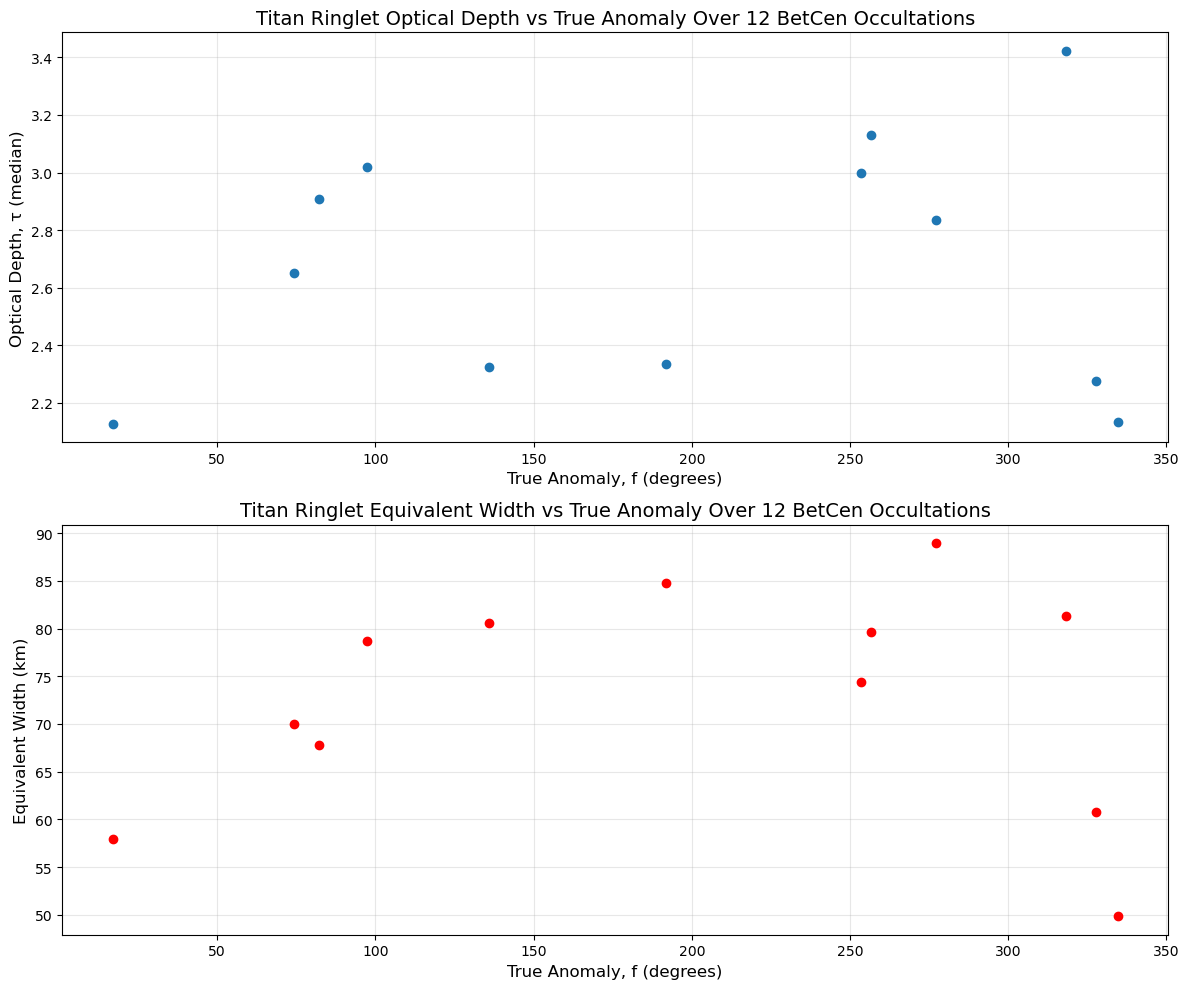

✓ Saved optical depth data to: /Volumes/Flash Drive/Saturns rings Research/Screenshot Outputs/True Anomoly:EQ width Graph and CSV data/Optical_Depth_vs_True_Anomaly.csv
✓ Saved equivalent width data to: /Volumes/Flash Drive/Saturns rings Research/Screenshot Outputs/True Anomoly:EQ width Graph and CSV data/Equivalent_Width_vs_True_Anomaly.csv
✓ Saved physical width analysis to: /Volumes/Flash Drive/Saturns rings Research/Screenshot Outputs/True Anomoly:EQ width Graph and CSV data/Physical_Width_Analysis.csv
✓ Saved optical depth graph to: /Volumes/Flash Drive/Saturns rings Research/Screenshot Outputs/True Anomoly:EQ width Graph and CSV data/Optical_Depth_vs_True_Anomaly.png
✓ Saved equivalent width graph to: /Volumes/Flash Drive/Saturns rings Research/Screenshot Outputs/True Anomoly:EQ width Graph and CSV data/Equivalent_Width_vs_True_Anomaly.png

ALL FILES SAVED TO:
  /Volumes/Flash Drive/Saturns rings Research/Screenshot Outputs/True Anomoly:EQ width Graph and CSV data



In [17]:
# ===== PLOTTING AND SAVING =====

# Define the output directory
output_dir = '/Volumes/Flash Drive/Saturns rings Research/Screenshot Outputs/True Anomoly:EQ width Graph and CSV data'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Optical Depth vs True Anomaly
ax1.plot(tau_df['true_anomaly'], tau_df['tau_median'], 'o', markersize=6, linewidth=1.5)
ax1.set_xlabel('True Anomaly, f (degrees)', fontsize=12)
ax1.set_ylabel('Optical Depth, τ (median)', fontsize=12)
ax1.set_title('Titan Ringlet Optical Depth vs True Anomaly Over 12 BetCen Occultations', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Equivalent Width vs True Anomaly
ax2.plot(eq_width_df['true_anomaly'], eq_width_df['equivalent_width'], 
         'o', markersize=6, linewidth=1.5, color='red')
ax2.set_xlabel('True Anomaly, f (degrees)', fontsize=12)
ax2.set_ylabel('Equivalent Width (km)', fontsize=12)
ax2.set_title('Titan Ringlet Equivalent Width vs True Anomaly Over 12 BetCen Occultations', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save the combined graph
graph_filename = os.path.join(output_dir, 'Titan_Ringlet_True_Anomaly_Analysis.png')
plt.savefig(graph_filename, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved combined graph to: {graph_filename}")

plt.show()

# ===== SAVE INDIVIDUAL DATAFRAMES TO CSV =====

# 1. Save Optical Depth data
tau_csv_filename = os.path.join(output_dir, 'Optical_Depth_vs_True_Anomaly.csv')
tau_df.to_csv(tau_csv_filename, index=False)
print(f"✓ Saved optical depth data to: {tau_csv_filename}")

# 2. Save Equivalent Width data
eq_width_csv_filename = os.path.join(output_dir, 'Equivalent_Width_vs_True_Anomaly.csv')
eq_width_df.to_csv(eq_width_csv_filename, index=False)
print(f"✓ Saved equivalent width data to: {eq_width_csv_filename}")

# 3. Save Physical Width Analysis data
width_csv_filename = os.path.join(output_dir, 'Physical_Width_Analysis.csv')
width_df.to_csv(width_csv_filename, index=False)
print(f"✓ Saved physical width analysis to: {width_csv_filename}")

# ===== OPTIONAL: SAVE SEPARATE GRAPHS =====

# Save Optical Depth graph separately
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(tau_df['true_anomaly'], tau_df['tau_median'], 'o', markersize=6)
ax1.set_xlabel('True Anomaly, f (degrees)', fontsize=12)
ax1.set_ylabel('Optical Depth, τ (median)', fontsize=12)
ax1.set_title('Titan Ringlet Optical Depth vs True Anomaly Over 12 BetCen Occultations', fontsize=14)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
optical_depth_graph = os.path.join(output_dir, 'Optical_Depth_vs_True_Anomaly.png')
plt.savefig(optical_depth_graph, dpi=300, bbox_inches='tight')
print(f"✓ Saved optical depth graph to: {optical_depth_graph}")
plt.close()

# Save Equivalent Width graph separately
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.plot(eq_width_df['true_anomaly'], eq_width_df['equivalent_width'], 
         'o', markersize=6, color='red')
ax2.set_xlabel('True Anomaly, f (degrees)', fontsize=12)
ax2.set_ylabel('Equivalent Width (km)', fontsize=12)
ax2.set_title('Titan Ringlet Equivalent Width vs True Anomaly Over 12 BetCen Occultations', fontsize=14)
ax2.grid(True, alpha=0.3)
plt.tight_layout()
eq_width_graph = os.path.join(output_dir, 'Equivalent_Width_vs_True_Anomaly.png')
plt.savefig(eq_width_graph, dpi=300, bbox_inches='tight')
print(f"✓ Saved equivalent width graph to: {eq_width_graph}")
plt.close()

print(f"\n{'='*80}")
print(f"ALL FILES SAVED TO:")
print(f"  {output_dir}")
print(f"{'='*80}\n")